# Hello NeMo-Run Experiments!

This is the second part of our hello world tutorial series for NeMo-Run. Please make sure that you have gone through the [first part](hello_world.ipynb) beforehand, since this tutorial builds heavily on it.

A key component of NeMo-Run is `run.Experiment`. For an introduction to `run.Experiment`, refer to its docstring, which is also posted below:

`run.Experiment` is a context manager to launch and manage multiple runs using pure Python. It offers researchers with a simple and flexible way to create and manage their ML experiments. Building on the core components of NeMo-Run, `run.Experiment` can be used as an umbrella under which users can launch different configured functions across multiple remote clusters.

The `run.Experiment` context manager takes care of storing the run metadata, launching it on the specified cluster, and syncing the logs and artifacts. Additionally, `run.Experiment` also provides management tools to easily inspect and reproduce past experiments.
Some of the use cases that it enables are listed below:

1. Check the status and logs of a past experiment.
2. Reproduce a past experiment and rerun it.
3. Reconstruct a past experiment and relaunch it after some changes.
4. Compare different runs of the same experiment.

This API allows users to programmatically define their experiments entirely in Python. To illustrate the flexibility it provides, here are some use cases that can be supported by `run.Experiment` with just a few lines of code.

1. Launch a benchmarking run on different GPUs at the same time in parallel.
2. Launch a sequential data processing pipeline on a CPU heavy cluster.
3. Launch hyperparameter grid search runs on a single cluster in parallel.
4. Launch hyperparameter search runs distributed across all available clusters.

The docstring also includes some code examples. In this tutorial, we build on `add_object` from the previous tutorial to define a simple experiment and show its capabilities.

Let's get into it.


In [1]:
# SPDX-FileCopyrightText: Copyright (c) 2024 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Set up and imports
import nemo_run as run
from simple.add import SomeObject, add_object, commonly_used_object

## Configure the Python Functions

First, let's configure the functions we want to run in our experiments. You can configure multiple functions under an experiment. Here, we will configure two functions, which will be partials of `add_object` but with different parameters.

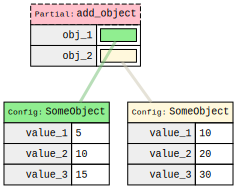

In [2]:
fn_1 = run.Partial(
    add_object,
    obj_1=commonly_used_object(),
    obj_2=run.Config(SomeObject, value_1=10, value_2=20, value_3=30),
)
fn_1

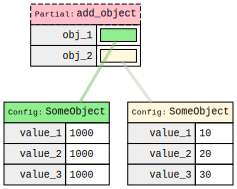

In [3]:
fn_2 = run.Partial(
    add_object,
    # You can also pass in the argument directly instead of as a Config.
    # However, this will run any code inside the `__init__` or `__post_init__` methods of the classes (if its a class).
    obj_1=SomeObject(value_1=1000, value_2=1000, value_3=1000),
    obj_2=run.Config(SomeObject, value_1=10, value_2=20, value_3=30),
)

fn_2

## Define and Run the Experiment

Now, let's say we want to run these two configured functions together and manage them under an experiment. We can do so with just a few lines of code shown below. Try running it: it will launch the two tasks sequentially and wait for them to complete.
Notice that we set `sequential=True`, this is because parallel execution mode is not supported on the local executor as of now. This is intentional as launching parallel processes on your local workstation can quickly eat up your limited resources.
However, our `SlurmExecutor` supports parallel mode, (and is set to `True` by default). This will allow you to run both of your configured functions in parallel. An example is shown below:

```python
with run.Experiment("add_object", executor=run.LocalExecutor()) as exp:
    exp.add(fn_1, tail_logs=True)
    exp.add(fn_2, tail_logs=True)
    exp.run()
```

Additionally, you can also launch the functions on separate executors as shown below:

```python
with run.Experiment("add_object", executor=run.LocalExecutor()) as exp:
    exp.add(fn_1, tail_logs=True)

    exp.add(fn_2, executor=your_slurm_executor(), tail_logs=True)
    exp.run()
```

The executor and configured functions are cloned in `exp.add` so you can mutate them as needed. This allows you to overwrite some parameters quickly. See the example below:
```python
with run.Experiment("add_object", executor=run.LocalExecutor()) as exp:
    exp.add(fn_1, tail_logs=True)

    fn_1.obj_1.value_1 = 0
    exp.add(fn_1, executor=your_slurm_executor(), tail_logs=True)
    exp.run()
```

>📝 Currently, we only support sequential and parallel execution in an experiment. Directed Acyclic Graph (DAG) based execution is not yet supported.
>📝 To run the tasks in an experiment in parallel, all executors should support parallel mode as of now. We will relax this restriction soon.

>📝 By default, the experiment metadata is stored in your home folder `~` inside the `.nemo_run` folder. However, you can also store it in a separate dir by setting the `NEMORUN_HOME` environment variable.


In [5]:
with run.Experiment("add_object", executor=run.LocalExecutor()) as exp:
    exp.add(fn_1, tail_logs=True)
    exp.add(fn_2, tail_logs=True)
    exp.run()

────────────────────────── Entering Experiment add_object with id: add_object_1748308731 ──────────────────────────

Log directory is: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748308731/simple.add.add_object
Log directory is: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748308731/simple.add.add_object_1


[21:18:51] Launching job simple.add.add_object for experiment add_object                          ]8;id=436140;file:///Users/erlebach/src/2025/gordon_nemo/.venv/lib/python3.10/site-packages/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=66826;file:///Users/erlebach/src/2025/gordon_nemo/.venv/lib/python3.10/site-packages/nemo_run/run/experiment.py#744\744]8;;\

Log directory is: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748308731/simple.add.add_object
Launched app: local_persistent://nemo_run/simple.add.add_object-mbpd6wrwkzfjhc


           Launching job simple.add.add_object_1 for experiment add_object                        ]8;id=941467;file:///Users/erlebach/src/2025/gordon_nemo/.venv/lib/python3.10/site-packages/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=618845;file:///Users/erlebach/src/2025/gordon_nemo/.venv/lib/python3.10/site-packages/nemo_run/run/experiment.py#744\744]8;;\

Log directory is: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748308731/simple.add.add_object_1
Launched app: local_persistent://nemo_run/simple.add.add_object_1-vbltnw4vrdtpp


───────────────────────────── Waiting for Experiment add_object_1748308731 to finish ──────────────────────────────

Experiment Status for add_object_1748308731

Task 0: simple.add.add_object
- Status: RUNNING
- Executor: LocalExecutor
- Job id: simple.add.add_object-mbpd6wrwkzfjhc
- Local Directory: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748308731/simple.add.add_object

Task 1: simple.add.add_object_1
- Status: RUNNING
- Executor: LocalExecutor
- Job id: simple.add.add_object_1-vbltnw4vrdtpp
- Local Directory: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748308731/simple.add.add_object_1

Waiting for job simple.add.add_object-mbpd6wrwkzfjhc to finish [log=True]...
Waiting for job simple.add.add_object_1-vbltnw4vrdtpp to finish [log=True]...


add_object/0 result = SomeObject(value_1=15, value_2=30, value_3=45)
d_object_1/0 result = SomeObject(value_1=1010, value_2=1020, value_3=1030)


Job simple.add.add_object-mbpd6wrwkzfjhc finished: SUCCEEDED
Job simple.add.add_object_1-vbltnw4vrdtpp finished: SUCCEEDED


                                                                                                                   
# The experiment was run with the following tasks: ['simple.add.add_object', 'simple.add.add_object_1']            
# You can inspect and reconstruct this experiment at a later point in time using:                                  
experiment = run.Experiment.from_id("add_object_1748308731")                                                       
experiment.status() # Gets the overall status                                                                      
experiment.logs("simple.add.add_object") # Gets the log for the provided task                                      
experiment.cancel("simple.add.add_object") # Cancels the provided task if still running                            
                                                                                                                   

                                                                                                                   
# You can inspect this experiment at a later point in time using the CLI as well:                                  
nemo experiment status add_object_1748308731                                                                       
nemo experiment logs add_object_1748308731 0                                                                       
nemo experiment cancel add_object_1748308731 0                                                                     
                                                                                                                   

## Inspect the Experiment

Additionally, you can also reconstruct and inspect an old experiment. There are a few utilities which allow you to list and inspect an experiment run. 
Run the cells below to see the current management capabilities.

In [13]:
# List all runs of an experiment
# The last suffix is the timestamp and results are sorted in ascending order of timestamps
run.Experiment.catalog("simple.add.add_object")

['simple.add.add_object_1748307099']

In [18]:
# Reconstruct an experiment and inspect its status, logs, etc
# if id is None, it will take the latest run.
# if id is provided, it will use that particular run.
# status and logs can be used outside the context manager too
with run.Experiment.from_title("add_object") as exp:
    exp.status()
    exp.logs(job_id="simple.add.add_object")

────────────────────────── Entering Experiment add_object with id: add_object_1748308731 ──────────────────────────

Experiment Status for add_object_1748308731

Task 0: simple.add.add_object
- Status: SUCCEEDED
- Executor: LocalExecutor
- Job id: simple.add.add_object-mbpd6wrwkzfjhc
- Local Directory: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748308731/simple.add.add_object

Task 1: simple.add.add_object_1
- Status: SUCCEEDED
- Executor: LocalExecutor
- Job id: simple.add.add_object_1-vbltnw4vrdtpp
- Local Directory: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748308731/simple.add.add_object_1

[21:24:27] Fetching logs for simple.add.add_object                                                ]8;id=599210;file:///Users/erlebach/src/2025/gordon_nemo/.venv/lib/python3.10/site-packages/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=801075;file:///Users/erlebach/src/2025/gordon_nemo/.venv/lib/python3.10/site-packages/nemo_run/run/experiment.py#931\931]8;;\

add_object/0 result = SomeObject(value_1=15, value_2=30, value_3=45)


In [19]:
# Create a new run of an old experiment
exp = run.Experiment.from_title("add_object")
with exp.reset():
    # Change the experimental tree structure
    exp.tasks[0].obj_1 = exp.tasks[1].obj_1.clone()
    exp.run(sequential=True)

────────────────────────── Entering Experiment add_object with id: add_object_1748309156 ──────────────────────────

Log directory is: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748309156/simple.add.add_object
Log directory is: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748309156/simple.add.add_object_1


[21:25:56] Dependencies not supported for atleast one of {<class                                  ]8;id=844347;file:///Users/erlebach/src/2025/gordon_nemo/.venv/lib/python3.10/site-packages/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=668825;file:///Users/erlebach/src/2025/gordon_nemo/.venv/lib/python3.10/site-packages/nemo_run/run/experiment.py#725\725]8;;\
           'nemo_run.core.execution.local.LocalExecutor'>}.All jobs will be run one after the                      
           other based on their dependencies, please keep the process alive.                                       

           Launching job simple.add.add_object for experiment add_object                          ]8;id=474078;file:///Users/erlebach/src/2025/gordon_nemo/.venv/lib/python3.10/site-packages/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=100076;file:///Users/erlebach/src/2025/gordon_nemo/.venv/lib/python3.10/site-packages/nemo_run/run/experiment.py#744\744]8;;\

Log directory is: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748309156/simple.add.add_object
Launched app: local_persistent://nemo_run/simple.add.add_object-vk30vlw0q1hcgd
Waiting for job simple.add.add_object-vk30vlw0q1hcgd to finish [log=True]...


add_object/0 result = SomeObject(value_1=1010, value_2=1020, value_3=1030)


Job simple.add.add_object-vk30vlw0q1hcgd finished: SUCCEEDED


[21:25:58] Launching job simple.add.add_object_1 for experiment add_object                        ]8;id=68953;file:///Users/erlebach/src/2025/gordon_nemo/.venv/lib/python3.10/site-packages/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=42186;file:///Users/erlebach/src/2025/gordon_nemo/.venv/lib/python3.10/site-packages/nemo_run/run/experiment.py#744\744]8;;\

Log directory is: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748309156/simple.add.add_object_1
Launched app: local_persistent://nemo_run/simple.add.add_object_1-zj1hnkrlmgqpvd
Waiting for job simple.add.add_object_1-zj1hnkrlmgqpvd to finish [log=True]...


d_object_1/0 result = SomeObject(value_1=1010, value_2=1020, value_3=1030)


Job simple.add.add_object_1-zj1hnkrlmgqpvd finished: SUCCEEDED


──────────────────────────────── Done waiting for Experiment add_object_1748309156 ────────────────────────────────

Experiment Status for add_object_1748309156

Task 0: simple.add.add_object
- Status: SUCCEEDED
- Executor: LocalExecutor
- Job id: simple.add.add_object-vk30vlw0q1hcgd
- Local Directory: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748309156/simple.add.add_object

Task 1: simple.add.add_object_1
- Status: SUCCEEDED
- Executor: LocalExecutor
- Job id: simple.add.add_object_1-zj1hnkrlmgqpvd
- Local Directory: /Users/erlebach/.nemo_run/experiments/add_object/add_object_1748309156/simple.add.add_object_1

                                                                                                                   
# The experiment was run with the following tasks: ['simple.add.add_object', 'simple.add.add_object_1']            
# You can inspect and reconstruct this experiment at a later point in time using:                                  
experiment = run.Experiment.from_id("add_object_1748309156")                                                       
experiment.status() # Gets the overall status                                                                      
experiment.logs("simple.add.add_object") # Gets the log for the provided task                                      
experiment.cancel("simple.add.add_object") # Cancels the provided task if still running                            
                                                                                                                   

                                                                                                                   
# You can inspect this experiment at a later point in time using the CLI as well:                                  
nemo experiment status add_object_1748309156                                                                       
nemo experiment logs add_object_1748309156 0                                                                       
nemo experiment cancel add_object_1748309156 0                                                                     
                                                                                                                   

For more information on how to inspect and reproduce experiments, please refer to the [inspect experiment tutorial](../experiments/inspect-experiment.ipynb).

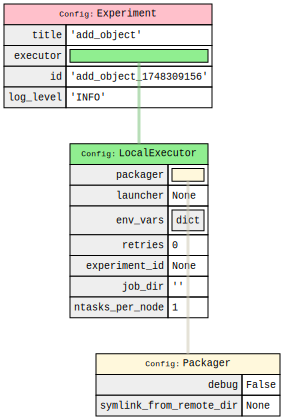

In [20]:
# Visualize the experiment configuration
exp

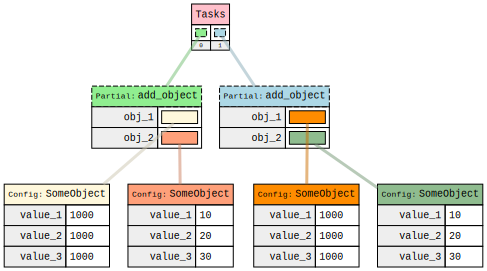

In [21]:
# Visualize tasks within the experiment
exp.tasks

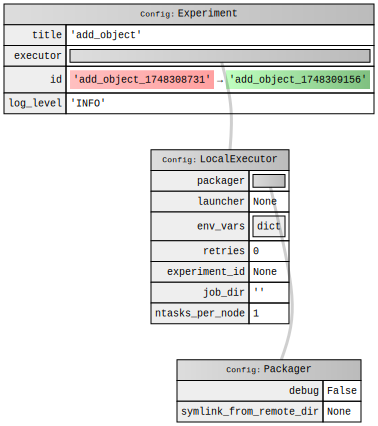

In [22]:
# Diff two experiments
old_exp = run.Experiment.from_id(run.Experiment.catalog("add_object")[-2])
exp.diff(old_exp, trim=False)

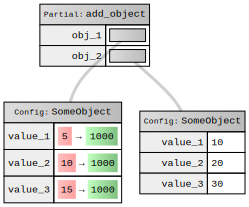

In [23]:
exp.tasks[0].diff(old_exp.tasks[0], trim=False)